### Time Series Analysis on Greenland Ground Temperatures from 1823 - 2013


In [96]:
import numpy as np
import pandas as pd

#working with dates/tsa
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# evaluate performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt

#for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

# turn off warning boxes for presentation purposes
import warnings
warnings.filterwarnings("ignore")

In [97]:
# read csv to a dataframe
df = pd.read_csv('GlobalLandTemperaturesbyCountry.csv')

#look at initial rows, transposed
df.head().T
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


#### Takeaways for Prepping Data: 
1. dt to datetime
2. set index
3. sort values by date
4. keep only Greenland data
5. drop unnecessary columns (Country)


In [99]:
def wrangle_gltemps():
    
    '''
    This function reads the Global Land Temperatures by Country data from csv 
    into a data frame. It removes data for all other countries except Greenland, renames 
    the dt column to "Date", converts Date to datetime object, sorts it by date and 
    sets Date as the index of the dataframe. Unnecessary column 'Country' is removed 
    and a dataframe with only Greenland data is returned.
    '''
    
    # read csv to a dataframe
    df = pd.read_csv('GlobalLandTemperaturesbyCountry.csv')
    
    # keep only Texas data
    df = df[df.Country == 'Greenland']
    
    #rename dt column to Date and other columns for readability
    df.rename(columns = {'dt': 'Date', 
                         'AverageTemperature':'Average_Temp',
                         'AverageTemperatureUncertainty':'Average_Uncertainty'}, 
                          inplace = True)
    
    # convert dt datetime format
    df['Date'] = pd.to_datetime(df.Date)
    
    # sort values by date
    df = df.sort_values('Date')
    
    # set index
    df = df.set_index('Date')

    # drop unneccesary column
    df = df.drop(columns=['Country'])
    
    return df
    


In [100]:
df = wrangle_gltemps()
df.head(2)

,Average_Temp,Average_Uncertainty
Date,,
1823-01-01,-29.921,3.768
1823-02-01,-32.374,3.495


In [101]:
# check that for data shape and type and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2289 entries, 1823-01-01 to 2013-09-01
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Average_Temp         2288 non-null   float64
 1   Average_Uncertainty  2288 non-null   float64
dtypes: float64(2)
memory usage: 53.6 KB


In [102]:
# ensure all Date entries are unique (no duplicates) 
df.value_counts('Date')

Date
2013-09-01    1
1886-04-01    1
1886-10-01    1
1886-09-01    1
1886-08-01    1
             ..
1950-08-01    1
1950-09-01    1
1950-10-01    1
1950-11-01    1
1823-01-01    1
Length: 2289, dtype: int64

#### 1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.

In [103]:
# train size will be 50% of the total
train_size = int(len(df) * .5)
train_size

1144

In [104]:
# validate will be 30% of total entries
validate_size = int(len(df) * .3)
validate_size

686

In [105]:
# test size will be the remaining rows
test_size = int(len(df) - train_size - validate_size)
test_size

459

In [106]:
# validate will start at 1162 and go through 1162+697 (train + validate)
validate_end_index = train_size + validate_size
validate_end_index

1830

In [107]:
# use the above values to split our data

# train will go from 0 to 1161
train = df[: train_size]

# validate will go from 1162 to 1858
validate = df[train_size:validate_end_index]

# test will include 1859 to the end
test = df[validate_end_index:]

#### Verifying splits are correct

In [108]:
# verifying splits 
print(len(train) + len(validate) + len(test) == len(df))

True


In [109]:
#is first row of df qual to first row of train?
print(df.head(1) == train.head(1))

            Average_Temp  Average_Uncertainty
Date                                         
1823-01-01          True                 True


In [110]:
#Is the last row of train the month before the first row of validate?
pd.concat([train.tail(1), validate.head(1)])

,Average_Temp,Average_Uncertainty
Date,,
1918-04-01,-25.274,2.077
1918-05-01,-10.611,1.627


In [111]:
#Is the last row of validate the month before the first row of test?
pd.concat([validate.tail(1), test.head(1)])

,Average_Temp,Average_Uncertainty
Date,,
1975-06-01,-5.179,0.731
1975-07-01,-1.777,0.708


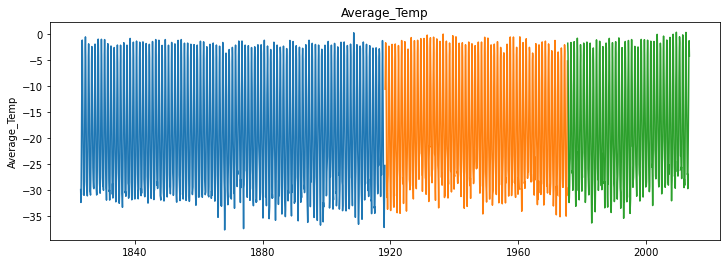

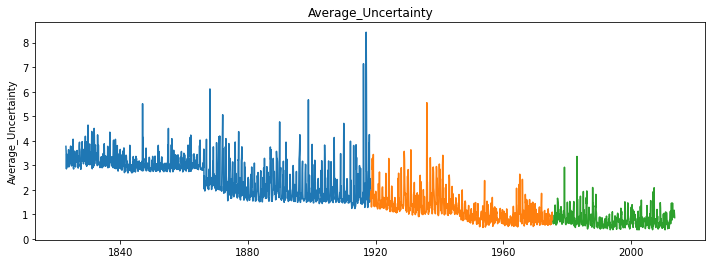

In [112]:
# verifying splits with visualization
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [129]:
y = train.Average_Temp

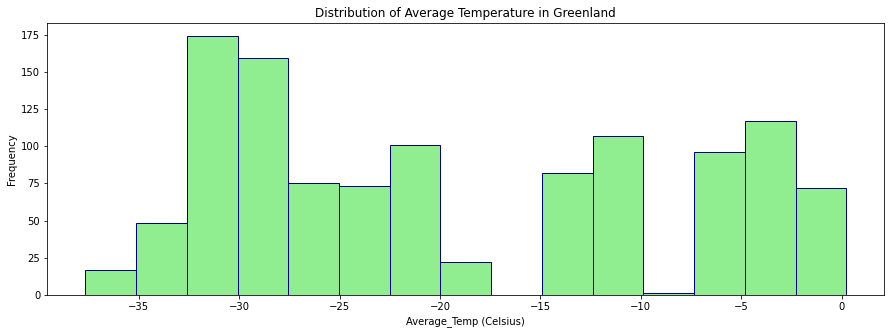

In [130]:
#look at distribution of our target variable
plt.figure(figsize=(15, 5))
train.Average_Temp.plot.hist(bins = 15, color = 'lightgreen', edgecolor = 'darkblue')
plt.xlabel('Average_Temp (Celsius)')
plt.title('Distribution of Average Temperature in Greenland')
plt.show()

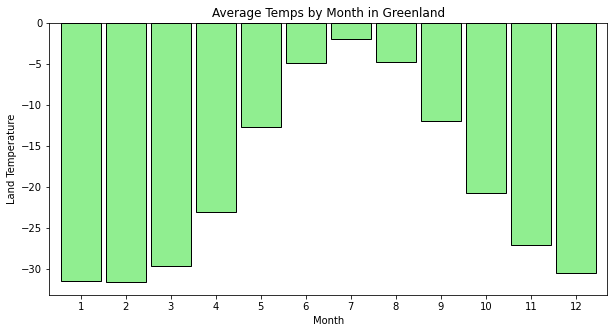

In [131]:
### Explore Average by month
plt.figure(figsize=(10, 5))
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, color = 'lightgreen', ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temps by Month in Greenland', xlabel='Month', ylabel='Land Temperature')
plt.show()

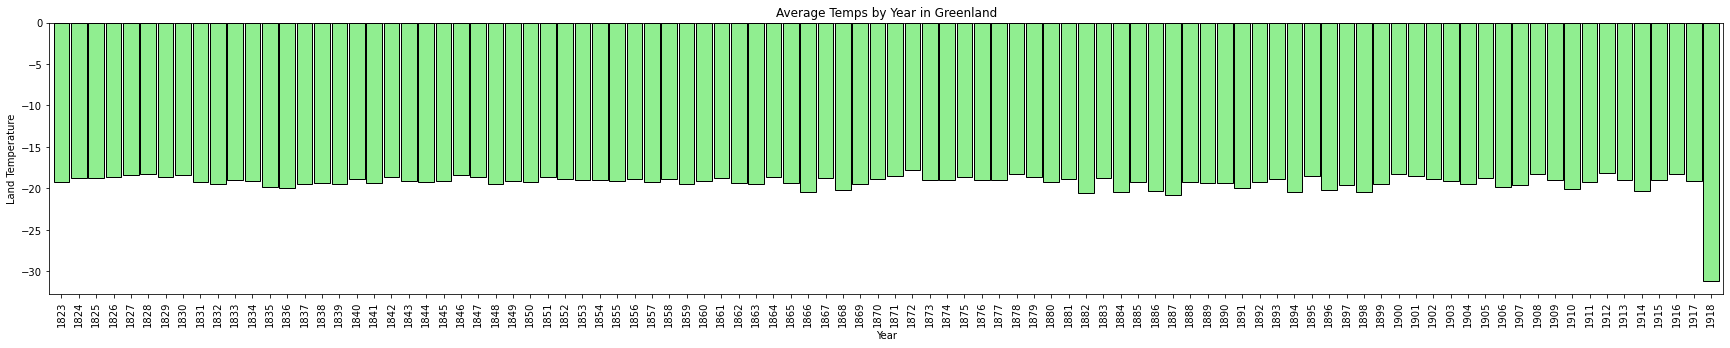

In [132]:
### Explore Average by year
plt.figure(figsize=(30, 5))
ax = y.groupby(y.index.year).mean().plot.bar(width=.9, color = 'lightgreen', ec='black')
plt.xticks(rotation=90)
ax.set(title='Average Temps by Year in Greenland', xlabel='Year', ylabel='Land Temperature')
plt.show()

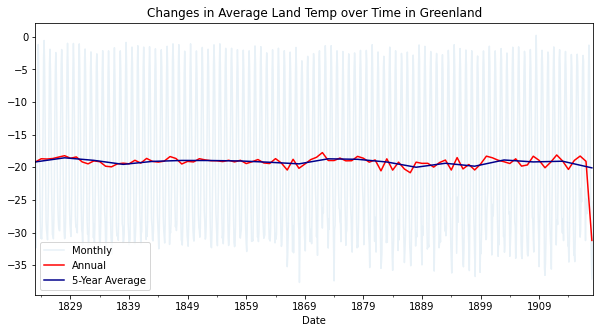

In [133]:
# Visualize target over time - monthly, yearly, decade
plt.figure(figsize=(10, 5))
plt.title('Changes in Average Land Temp over Time in Greenland')
y.plot(alpha=.1, label='Monthly')
# y.resample('M').mean().plot(alpha=.5, label='Monthly', color = 'tan')
y.resample('Y').mean().plot(label='Annual', color = 'red')
y.resample('5Y').mean().plot(label='5-Year Average', color = 'darkblue')
# y.resample('10Y').mean().plot(label='Decade', color = 'yellow')
plt.legend()
plt.show()

#### 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.

In [134]:
# convert Celsius temp to Fahrenheit

def c_to_f(c):
    '''
    this function takes in a Celsius temperature and converts it to Fahrenheit
    '''
    f = (c * 1.8) + 32
    return f

In [135]:
#evaluate function will compute MSE and RMSE

def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 4)
    return rmse

In [136]:
# plot and eval function will use the evaluate function ^^^ and also 
# plot train and test values with the predicted values in order to compare performance

def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will also label the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.4f}'.format(rmse))
    plt.show()

write append_eval_df(model_type) to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our eval_df data frame object. Which we will create an empty eval_df dataframe object to start.


In [137]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type','target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [138]:
#function to store the rmse so that we can compare

def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [139]:
eval_df

,model_type,target_var,rmse


### Simple Average
- this simply takes the average of historical values and uses that to predict future values.
- Each future datapoint (test data) will be assigned the value of the mean in train.
- good option for an initial baseline

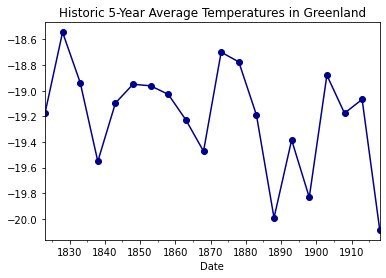

In [142]:
y.resample('5Y').mean().plot(label='5-Year Average', color = 'darkblue', marker = 'o')
plt.title('Historic 5-Year Average Temperatures in Greenland')
plt.show()

In [143]:
# compute the simple average of train temps
temps = round(train['Average_Temp'].mean(),1)
temps

-19.2

In [144]:
# compute the simple average of train uncertainty
uncert = round(train['Average_Uncertainty'].mean(),2)
uncert

2.59

In [145]:
# apply predictions to our observations
def make_predictions():
    yhat_df = pd.DataFrame({'Average_Temp': [temps], 'Average_Uncertainty':[uncert]}, index = validate.index)
    return yhat_df



In [146]:
yhat_df = make_predictions()

In [147]:
yhat_df.head()

,Average_Temp,Average_Uncertainty
Date,,
1918-05-01,-19.2,2.59
1918-06-01,-19.2,2.59
1918-07-01,-19.2,2.59
1918-08-01,-19.2,2.59
1918-09-01,-19.2,2.59


In [148]:
yhat_df.describe()

,Average_Temp,Average_Uncertainty
count,6.860000e+02,6.860000e+02
mean,-1.920000e+01,2.590000e+00
std,1.955418e-13,2.888686e-14
min,-1.920000e+01,2.590000e+00
25%,-1.920000e+01,2.590000e+00
50%,-1.920000e+01,2.590000e+00
75%,-1.920000e+01,2.590000e+00
max,-1.920000e+01,2.590000e+00


#### Plot Actual Temperature v. Predicted Temperature using **Simple Average**

Average_Temp -- RMSE: 10.6909


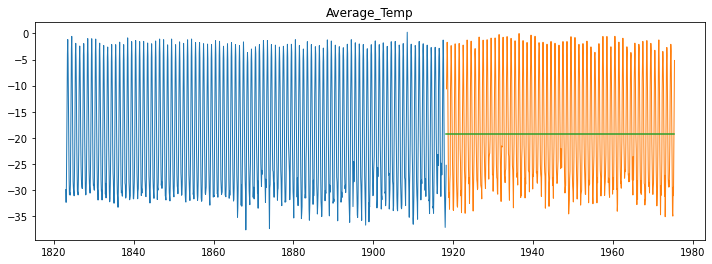

Average_Uncertainty -- RMSE: 1.4767


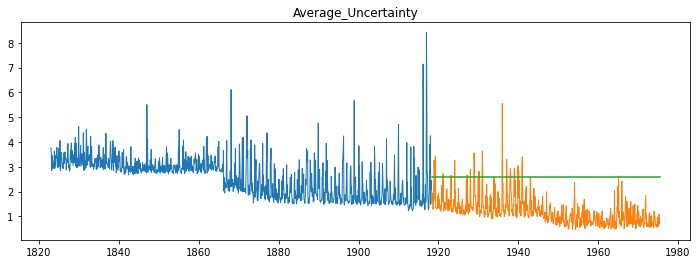

In [149]:
for col in train.columns:
    plot_and_eval(col)

In [150]:
eval_df

,model_type,target_var,rmse


In [151]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,simple_average,Average_Temp,10.6909
1,simple_average,Average_Uncertainty,1.4767


### Moving Average

- using a 12-month moving average to forecast. 
- this means the average over the last 12-months will be used as the forecasted value.

In [152]:
# look at the last 12-months on the train data -- the average of these will be used as our forecasted value
train['Average_Temp'].tail(12)

Date
1917-05-01   -14.450
1917-06-01    -5.941
1917-07-01    -1.266
1917-08-01    -4.390
1917-09-01   -13.199
1917-10-01   -23.634
1917-11-01   -30.496
1917-12-01   -33.687
1918-01-01   -37.177
1918-02-01   -33.366
1918-03-01   -29.029
1918-04-01   -25.274
Name: Average_Temp, dtype: float64

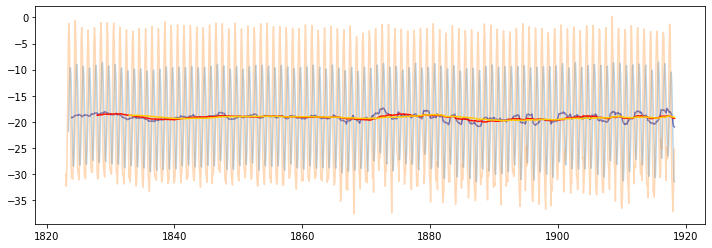

In [153]:
plt.figure(figsize=(12,4))
plt.plot(train['Average_Temp'].rolling(6).mean(), alpha = .3)
plt.plot(train['Average_Temp'].rolling(12).mean(), alpha = .5, color = 'darkblue')
plt.plot(train['Average_Temp'].rolling(60).mean(), color = 'red')
plt.plot(train['Average_Temp'].rolling(120).mean(), color = 'gold')
plt.plot(train['Average_Temp'], alpha=.3)

#### Making Predictions using Rolling Average - 12 months

In [154]:
period = 12 

# take 12 month rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
temps = round(train['Average_Temp'].rolling(period).mean()[-1], 2)
uncert = round(train['Average_Uncertainty'].rolling(period).mean()[-1], 2)

print(temps, uncert)

-20.99 2.28


In [155]:
yhat_df = make_predictions()
yhat_df.head()

,Average_Temp,Average_Uncertainty
Date,,
1918-05-01,-20.99,2.28
1918-06-01,-20.99,2.28
1918-07-01,-20.99,2.28
1918-08-01,-20.99,2.28
1918-09-01,-20.99,2.28


**Plot Actual vs. Predicted Values** using Rolling Average

Average_Temp -- RMSE: 11.0250


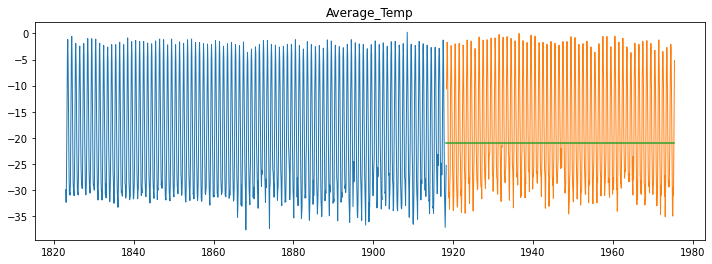

Average_Uncertainty -- RMSE: 1.1979


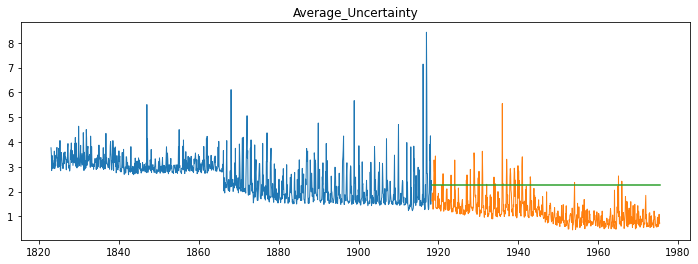

In [156]:
for col in train.columns:
    plot_and_eval(col)

In [157]:
# Evaluate using MSE and RMSE, and add evaluation metrics to our eval dataframe
for col in train.columns:
    eval_df = append_eval_df(model_type = '12_month_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,simple_average,Average_Temp,10.6909
1,simple_average,Average_Uncertainty,1.4767
2,12_month_moving_avg,Average_Temp,11.0250
3,12_month_moving_avg,Average_Uncertainty,1.1979


#### Making Predictions using Rolling Average - 60 months

In [158]:
period = 60 

# take 60 month rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
temps = round(train['Average_Temp'].rolling(period).mean()[-1], 2)
uncert = round(train['Average_Uncertainty'].rolling(period).mean()[-1], 2)

print(temps, uncert)

-19.34 2.25


In [159]:
yhat_df = make_predictions()
yhat_df.head()

,Average_Temp,Average_Uncertainty
Date,,
1918-05-01,-19.34,2.25
1918-06-01,-19.34,2.25
1918-07-01,-19.34,2.25
1918-08-01,-19.34,2.25
1918-09-01,-19.34,2.25


**Plot Actual vs. Predicted Values** using Rolling Average

Average_Temp -- RMSE: 10.7066


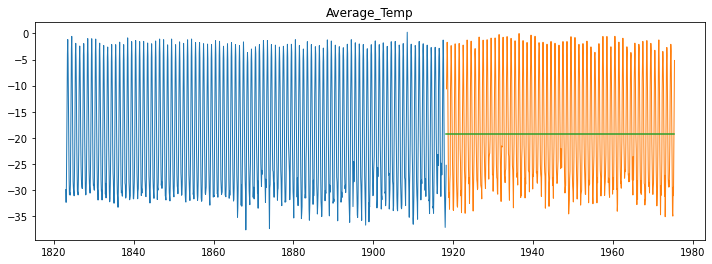

Average_Uncertainty -- RMSE: 1.1717


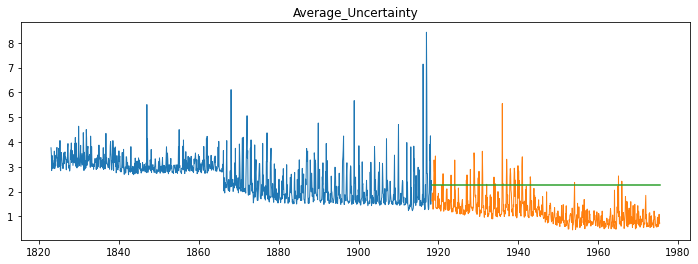

In [160]:
for col in train.columns:
    plot_and_eval(col)

In [161]:
# Evaluate using MSE and RMSE, and add evaluation metrics to our eval dataframe
for col in train.columns:
    eval_df = append_eval_df(model_type = '60_month_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,simple_average,Average_Temp,10.6909
1,simple_average,Average_Uncertainty,1.4767
2,12_month_moving_avg,Average_Temp,11.0250
3,12_month_moving_avg,Average_Uncertainty,1.1979
4,60_month_moving_avg,Average_Temp,10.7066
5,60_month_moving_avg,Average_Uncertainty,1.1717


#### Making Predictions using Rolling Average - 120 months

In [162]:
period = 120 

# take 120 month rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
temps = round(train['Average_Temp'].rolling(period).mean()[-1], 2)
uncert = round(train['Average_Uncertainty'].rolling(period).mean()[-1], 2)

print(temps, uncert)

-19.16 2.05


In [163]:
yhat_df = make_predictions()
yhat_df.head()

,Average_Temp,Average_Uncertainty
Date,,
1918-05-01,-19.16,2.05
1918-06-01,-19.16,2.05
1918-07-01,-19.16,2.05
1918-08-01,-19.16,2.05
1918-09-01,-19.16,2.05


**Plot Actual vs. Predicted Values** using Rolling Average

Average_Temp -- RMSE: 10.6867


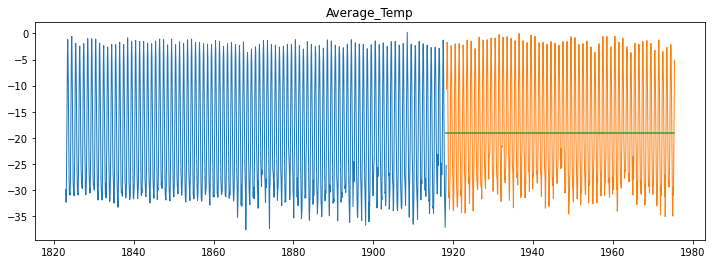

Average_Uncertainty -- RMSE: 1.0029


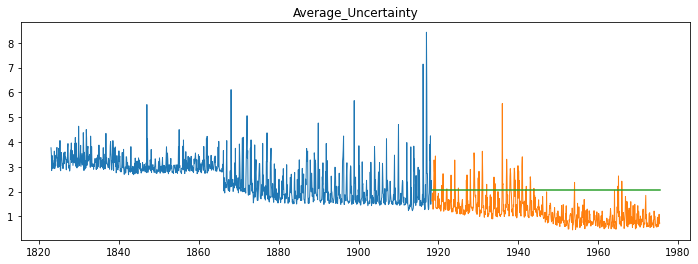

In [164]:
for col in train.columns:
    plot_and_eval(col)

In [165]:
# Evaluate using MSE and RMSE, and add evaluation metrics to our eval dataframe
for col in train.columns:
    eval_df = append_eval_df(model_type = '120_month_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,simple_average,Average_Temp,10.6909
1,simple_average,Average_Uncertainty,1.4767
2,12_month_moving_avg,Average_Temp,11.0250
3,12_month_moving_avg,Average_Uncertainty,1.1979
4,60_month_moving_avg,Average_Temp,10.7066
5,60_month_moving_avg,Average_Uncertainty,1.1717
6,120_month_moving_avg,Average_Temp,10.6867
7,120_month_moving_avg,Average_Uncertainty,1.0029


#### Making Predictions using Rolling Average - 6 months

In [166]:
period = 6 

# take 6 month rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
temps = round(train['Average_Temp'].rolling(period).mean()[-1], 2)
uncert = round(train['Average_Uncertainty'].rolling(period).mean()[-1], 2)

print(temps, uncert)

-31.5 2.9


In [167]:
yhat_df = make_predictions()
yhat_df.head()

,Average_Temp,Average_Uncertainty
Date,,
1918-05-01,-31.5,2.9
1918-06-01,-31.5,2.9
1918-07-01,-31.5,2.9
1918-08-01,-31.5,2.9
1918-09-01,-31.5,2.9


**Plot Actual vs. Predicted Values** using Rolling Average

Average_Temp -- RMSE: 17.1294


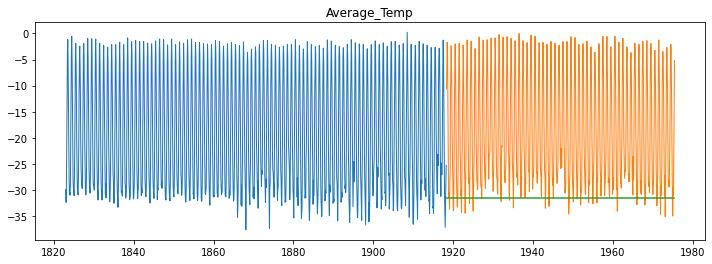

Average_Uncertainty -- RMSE: 1.7659


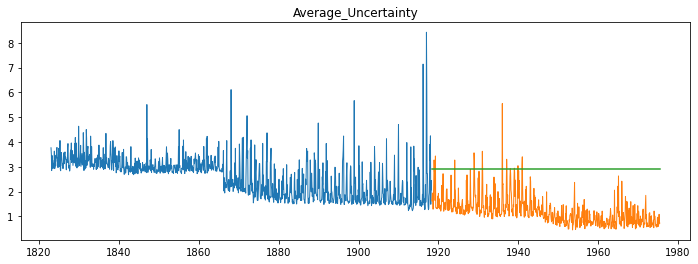

In [168]:
for col in train.columns:
    plot_and_eval(col)

In [169]:
# Evaluate using MSE and RMSE, and add evaluation metrics to our eval dataframe
for col in train.columns:
    eval_df = append_eval_df(model_type = '6_month_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,simple_average,Average_Temp,10.6909
1,simple_average,Average_Uncertainty,1.4767
2,12_month_moving_avg,Average_Temp,11.0250
3,12_month_moving_avg,Average_Uncertainty,1.1979
4,60_month_moving_avg,Average_Temp,10.7066
5,60_month_moving_avg,Average_Uncertainty,1.1717
6,120_month_moving_avg,Average_Temp,10.6867
7,120_month_moving_avg,Average_Uncertainty,1.0029
8,6_month_moving_avg,Average_Temp,17.1294
9,6_month_moving_avg,Average_Uncertainty,1.7659


### Holt's Linear Trend
- Applies exponential smoothing to both the average and the trend, or slope.
- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 

**Seasonal Decomposition**
First, let's take a look at the seasonal decomposition for each target. 

In [170]:
import statsmodels.api as sm

Average_Temp 



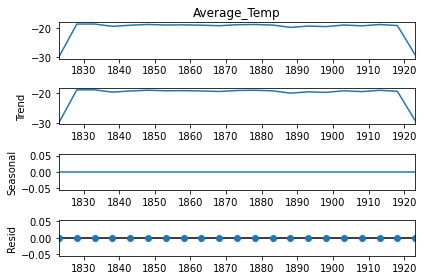

Average_Uncertainty 



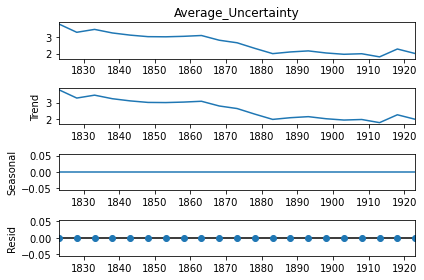

In [171]:
for col in train.columns:
    print(col, '\n')
    sm.tsa.seasonal_decompose(train[col].resample('60m').mean()).plot()
    plt.show()

#### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
- damped $\phi$ = True/False: with Holt, forecasts will increase or decrease indefinitely into the future.  To avoid this, use the Damped trend method which has a damping parameter 0< ϕ <1. 


fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)
- optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us. 

In [172]:
# doing this in a loop for each column, but we could separate out for clarity if needed. 
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_temps = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_temps, 2)

In [173]:
yhat_df

,Average_Temp,Average_Uncertainty
Date,,
1918-05-01,-22.27,2.43
1918-06-01,-19.87,2.43
1918-07-01,-17.94,2.43
1918-08-01,-16.41,2.43
1918-09-01,-15.18,2.44
...,...,...
1975-02-01,-10.25,2.51
1975-03-01,-10.25,2.51
1975-04-01,-10.25,2.51


### Plot Actual v. Predicted Values

Average_Temp -- RMSE: 13.2018


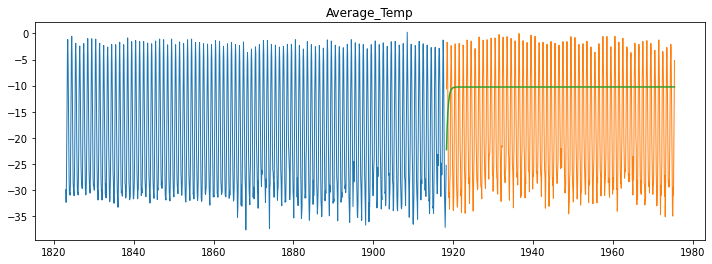

Average_Uncertainty -- RMSE: 1.4012


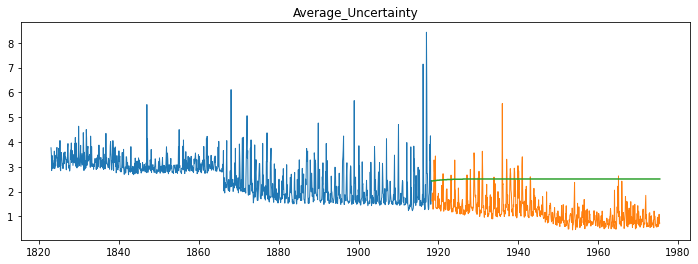

In [174]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [175]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [176]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
7,120_month_moving_avg,Average_Uncertainty,1.0029
5,60_month_moving_avg,Average_Uncertainty,1.1717
3,12_month_moving_avg,Average_Uncertainty,1.1979
11,holts_optimized,Average_Uncertainty,1.4012
1,simple_average,Average_Uncertainty,1.4767
9,6_month_moving_avg,Average_Uncertainty,1.7659
6,120_month_moving_avg,Average_Temp,10.6867
0,simple_average,Average_Temp,10.6909
4,60_month_moving_avg,Average_Temp,10.7066
2,12_month_moving_avg,Average_Temp,11.0250


### Modeling on Holt's again with new hyperparameters

In [177]:
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=.015, 
                      smoothing_slope=.125, 
                      optimized=False)
    yhat_temps = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_temps, 2)

Average_Temp -- RMSE: 33.2113


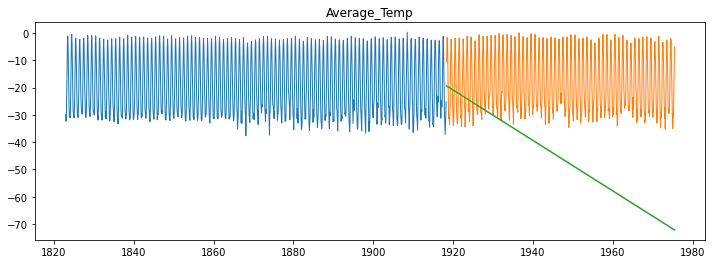

Average_Uncertainty -- RMSE: 11.2850


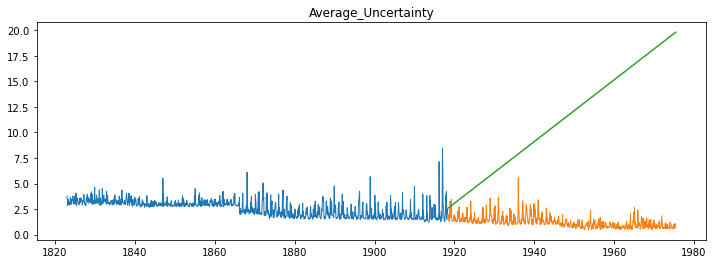

In [178]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [179]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = col)
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
7,120_month_moving_avg,Average_Uncertainty,1.0029
5,60_month_moving_avg,Average_Uncertainty,1.1717
3,12_month_moving_avg,Average_Uncertainty,1.1979
11,holts_optimized,Average_Uncertainty,1.4012
1,simple_average,Average_Uncertainty,1.4767
9,6_month_moving_avg,Average_Uncertainty,1.7659
6,120_month_moving_avg,Average_Temp,10.6867
0,simple_average,Average_Temp,10.6909
4,60_month_moving_avg,Average_Temp,10.7066
2,12_month_moving_avg,Average_Temp,11.0250


In [180]:
df.tail()

,Average_Temp,Average_Uncertainty
Date,,
2013-05-01,-12.541,0.957
2013-06-01,-3.474,1.162
2013-07-01,-1.292,1.046
2013-08-01,-4.221,0.859
2013-09-01,NaN,NaN


### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. 

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

Let's get started....

**Re-split data**

In [181]:
train.tail()

,Average_Temp,Average_Uncertainty
Date,,
1917-12-01,-33.687,3.250
1918-01-01,-37.177,4.248
1918-02-01,-33.366,1.491
1918-03-01,-29.029,2.451
1918-04-01,-25.274,2.077


In [183]:
# Resplitting data
train = df[:'2010']
validate = df['2011']
test = df['2012']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(2256, 2)
(12, 2)
(12, 2)


,Average_Temp,Average_Uncertainty
Date,,
2010-08-01,-1.700,0.362
2010-09-01,-8.705,0.478
2010-10-01,-17.888,1.091
2010-11-01,-23.471,0.884
2010-12-01,-23.406,0.623


In [184]:
validate

,Average_Temp,Average_Uncertainty
Date,,
2011-01-01,-26.166,1.069
2011-02-01,-25.560,1.035
2011-03-01,-27.784,0.753
2011-04-01,-23.745,0.567
2011-05-01,-11.410,0.703
2011-06-01,-3.436,0.406
2011-07-01,-0.168,0.453
2011-08-01,-2.585,0.573
2011-09-01,-10.520,0.460


In [185]:
test

,Average_Temp,Average_Uncertainty
Date,,
2012-01-01,-27.880,0.747
2012-02-01,-29.103,0.619
2012-03-01,-28.943,0.849
2012-04-01,-20.614,1.118
2012-05-01,-10.866,0.611
2012-06-01,-3.243,0.921
2012-07-01,0.305,1.198
2012-08-01,-2.263,1.455
2012-09-01,-9.098,1.036


**Make Predictions**

In [186]:
# finding the year-over-year difference for each day from 2010 to 2012
# taking the mean, and then adding that value to the monthly values. 

# find yoy diff. from 2010-2011 and 2011-2012, take the mean, and add to each value in 2015. 
yhat_df = train['2010'] + train.diff(12).mean()
yhat_df

,Average_Temp,Average_Uncertainty
Date,,
2010-01-01,-27.294581,0.947764
2010-02-01,-25.820581,1.001764
2010-03-01,-26.323581,0.797764
2010-04-01,-19.498581,1.021764
2010-05-01,-8.565581,0.543764
2010-06-01,-3.235581,0.424764
2010-07-01,-0.511581,0.518764
2010-08-01,-1.680581,0.348764
2010-09-01,-8.685581,0.464764


Back to predictions

In [187]:
train.loc['2010'].head()

,Average_Temp,Average_Uncertainty
Date,,
2010-01-01,-27.314,0.961
2010-02-01,-25.840,1.015
2010-03-01,-26.343,0.811
2010-04-01,-19.518,1.035
2010-05-01,-8.585,0.557


In [188]:
yhat_df.head()

,Average_Temp,Average_Uncertainty
Date,,
2010-01-01,-27.294581,0.947764
2010-02-01,-25.820581,1.001764
2010-03-01,-26.323581,0.797764
2010-04-01,-19.498581,1.021764
2010-05-01,-8.565581,0.543764


In [189]:
# let's peek into the prediction we will make for 1/1/2011
# by comparing the predicted value 
# (2010 value + year-over-year average difference)
# to the actual 1/1/2011 value
pd.concat([yhat_df.head(1), validate.head(1)])

,Average_Temp,Average_Uncertainty
Date,,
2010-01-01,-27.294581,0.947764
2011-01-01,-26.166000,1.069000


In [190]:
# set yhat_df to index of validate

yhat_df.index = validate.index
yhat_df

,Average_Temp,Average_Uncertainty
Date,,
2011-01-01,-27.294581,0.947764
2011-02-01,-25.820581,1.001764
2011-03-01,-26.323581,0.797764
2011-04-01,-19.498581,1.021764
2011-05-01,-8.565581,0.543764
2011-06-01,-3.235581,0.424764
2011-07-01,-0.511581,0.518764
2011-08-01,-1.680581,0.348764
2011-09-01,-8.685581,0.464764


In [191]:
yhat_df.describe()

,Average_Temp,Average_Uncertainty
count,12.000000,12.000000
mean,-15.526914,0.719014
std,10.314861,0.261625
min,-27.294581,0.348764
25%,-24.043831,0.505264
50%,-18.683581,0.703764
75%,-7.233081,0.961264
max,-0.511581,1.077764


In [192]:
yhat_df.head()

,Average_Temp,Average_Uncertainty
Date,,
2011-01-01,-27.294581,0.947764
2011-02-01,-25.820581,1.001764
2011-03-01,-26.323581,0.797764
2011-04-01,-19.498581,1.021764
2011-05-01,-8.565581,0.543764


In [193]:
yhat_df.shape

(12, 2)

**Plot and Evaluate**

Average_Temp -- RMSE: 2.5772


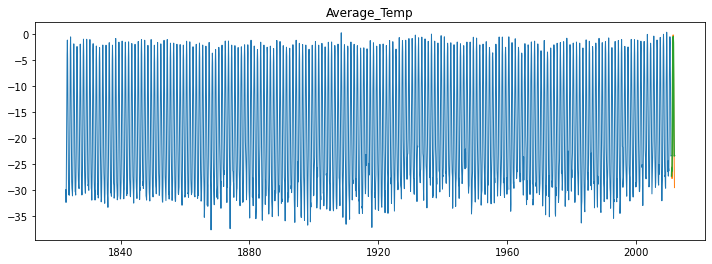

Average_Uncertainty -- RMSE: 0.2440


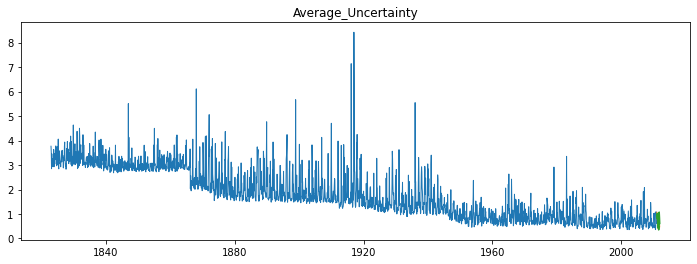

In [194]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

In [196]:
temps_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

uncert_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == temps_min_rmse) | 
         (eval_df.rmse == uncert_min_rmse))]

,model_type,target_var,rmse
14,previous_year,Average_Temp,2.5772
15,previous_year,Average_Uncertainty,0.2440


Let's test it out on our out-of-sample data

We will be using train + validate to predict test. 

In [197]:
yhat_df = validate + train.diff(12).mean()
yhat_df.index = test.index

In [198]:
yhat_df

,Average_Temp,Average_Uncertainty
Date,,
2012-01-01,-26.146581,1.055764
2012-02-01,-25.540581,1.021764
2012-03-01,-27.764581,0.739764
2012-04-01,-23.725581,0.553764
2012-05-01,-11.390581,0.689764
2012-06-01,-3.416581,0.392764
2012-07-01,-0.148581,0.439764
2012-08-01,-2.565581,0.559764
2012-09-01,-10.500581,0.446764


In [199]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)

    plt.show()

In [200]:
test

,Average_Temp,Average_Uncertainty
Date,,
2012-01-01,-27.880,0.747
2012-02-01,-29.103,0.619
2012-03-01,-28.943,0.849
2012-04-01,-20.614,1.118
2012-05-01,-10.866,0.611
2012-06-01,-3.243,0.921
2012-07-01,0.305,1.198
2012-08-01,-2.263,1.455
2012-09-01,-9.098,1.036


In [201]:
rmse_temps = sqrt(mean_squared_error(test['Average_Temp'], 
                                       yhat_df['Average_Temp']))

rmse_uncert = sqrt(mean_squared_error(test['Average_Uncertainty'], 
                                       yhat_df['Average_Uncertainty']))

In [202]:
print('rmse-average-temp: ', rmse_temps)
print('rmse-average-uncert: ', rmse_uncert)

rmse-average-temp:  1.8544306355905555
rmse-average-uncert:  0.5614966789127073


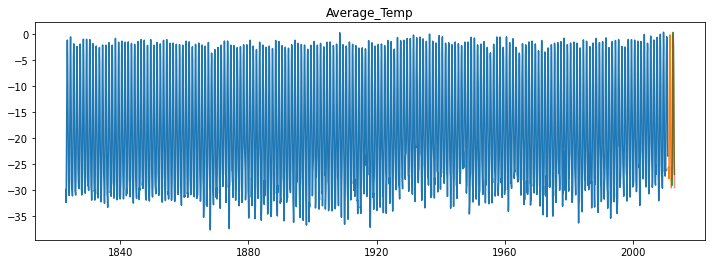

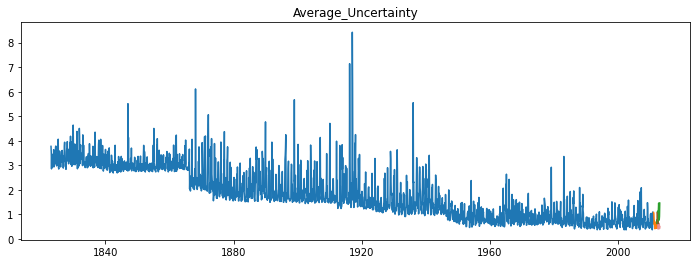

In [203]:
for col in train.columns:
    final_plot(col)

In [204]:
import datetime as dt

def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    left = dt.date(2000, 3, 15)
    right = dt.date(2015, 7, 15)
    plt.gca().set_xbound(left, right)
    plt.show()

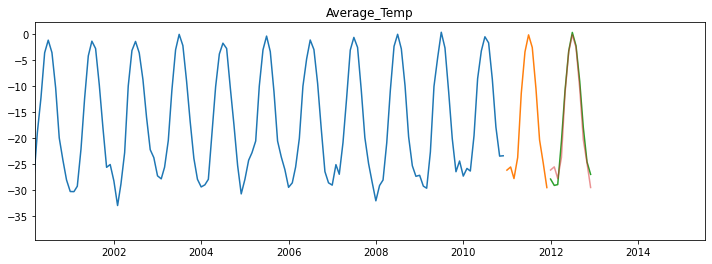

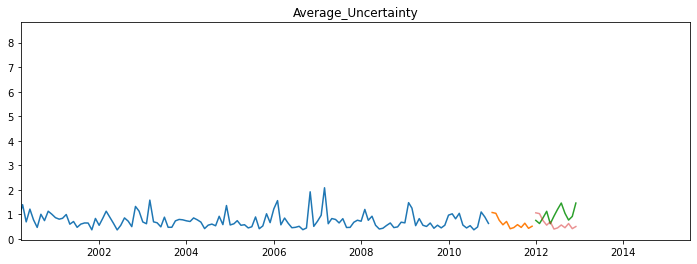

In [206]:
for col in train.columns:
    final_plot(col)

### Conclusion

Which model did the best?

In [207]:
temps_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

uncert_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == temps_min_rmse) | 
         (eval_df.rmse == uncert_min_rmse))]

,model_type,target_var,rmse
14,previous_year,Average_Temp,2.5772
15,previous_year,Average_Uncertainty,0.2440


In [208]:
# to predict upcoming year 
yhat_df = test + train.diff(12).mean()
yhat_df.index = test.index + pd.Timedelta('1Y')

In [209]:
yhat_df

,Average_Temp,Average_Uncertainty
Date,,
2012-12-31 05:49:12,-27.860581,0.733764
2013-01-31 05:49:12,-29.083581,0.605764
2013-03-01 05:49:12,-28.923581,0.835764
2013-04-01 05:49:12,-20.594581,1.104764
2013-05-01 05:49:12,-10.846581,0.597764
2013-06-01 05:49:12,-3.223581,0.907764
2013-07-01 05:49:12,0.324419,1.184764
2013-08-01 05:49:12,-2.243581,1.441764
2013-09-01 05:49:12,-9.078581,1.022764


In [210]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    left = dt.date(1970, 3, 15)
    right = dt.date(2015, 7, 15)
    plt.gca().set_xbound(left, right)
    plt.show()

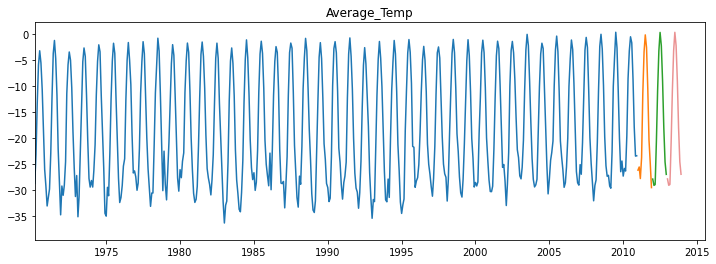

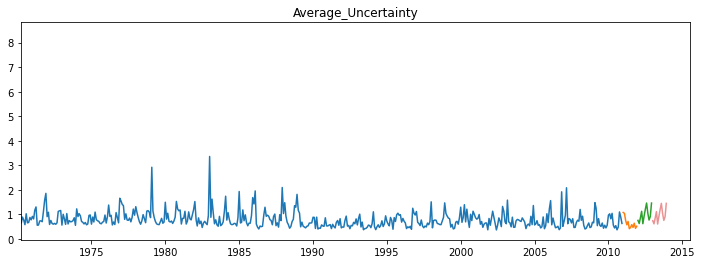

In [211]:
for col in train.columns:
    final_plot(col)